Howework 3- Justin Talbot

In [2]:
import wget
wget.download('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')

100% [..........................................................................] 1475504 / 1475504

'data (2).csv'

In [3]:
import pandas as pd
df = pd.read_csv('data.csv')


In [4]:
df = df[['Make','Model','Year','Engine HP','Engine Cylinders',
         'Transmission Type','Vehicle Style','highway MPG','city mpg','MSRP']]

In [5]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [6]:
df.isnull().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [7]:
df['engine_hp'] = df['engine_hp'].fillna(0).values

In [8]:
df['engine_cylinders'] = df['engine_cylinders'].fillna(0).values

In [9]:
df.rename(columns={'msrp':'price'},inplace=True)

Q1

In [10]:
df.mode()['transmission_type']

0    AUTOMATIC
Name: transmission_type, dtype: object

Q2

In [11]:
corr_matrix = df.corr()

<AxesSubplot:>

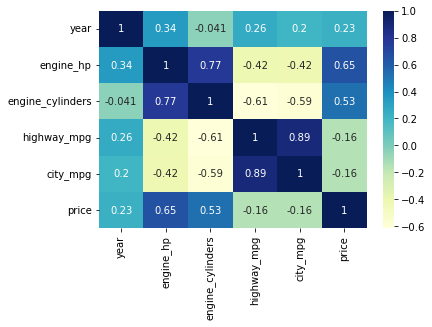

In [12]:
import seaborn as sns
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu')

In [13]:
df.describe()['price']['mean']

40594.737032063116

In [14]:
def above_average(price):
    return 1 if price > 40594.737032063116 else 0

In [15]:
df['above_average'] = df['price'].apply(above_average)

In [16]:
df.drop('price',axis = 1,inplace=True)

In [17]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

Q3

In [18]:
from sklearn.metrics import mutual_info_score
categorical = ['make','model','transmission_type','vehicle_style']
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.above_average)

mi = df_full_train[categorical].apply(mutual_info_churn_score).round(2)
mi.sort_values(ascending=False)

model                0.46
make                 0.24
vehicle_style        0.08
transmission_type    0.02
dtype: float64

Q4

In [19]:
numerical = ['year','engine_hp','engine_cylinders','highway_mpg','city_mpg']
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [20]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)


In [21]:
model.fit(X_train,y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [22]:
y_pred = model.predict_proba(X_val)[:,1]

In [23]:
above_average_decision = (y_pred >= 0.5)

In [24]:
(y_val == above_average_decision).mean()

0.9458665547629039

In [25]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = above_average_decision.astype(int)
df_pred['actual'] = y_val

In [26]:
df_pred['correct'] = df_pred.prediction == df_pred.actual

In [27]:
full_accuracy = df_pred.correct.mean()
print(full_accuracy)

0.9458665547629039


Q5

In [28]:
all_features = categorical + numerical
acc_diff = {}

In [29]:
for excl_feature in all_features[:]:
    feature_subset = list(all_features)
    feature_subset.remove(excl_feature)

    train_dict = df_train[feature_subset].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    
    val_dict = df_val[feature_subset].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
    model.fit(X_train,y_train)
    
    y_pred = model.predict_proba(X_val)[:,1]

    above_average_decision = (y_pred >= 0.5)

    accuracy = (y_val == above_average_decision).mean()
    
    acc_diff[excl_feature] = abs(accuracy - full_accuracy)

In [30]:
acc_diff
sorted(acc_diff.items(), key= lambda x:x[1])

[('make', 0.0004196391103650221),
 ('city_mpg', 0.0004196391103650221),
 ('transmission_type', 0.0008392782207301552),
 ('engine_cylinders', 0.0012589173310951773),
 ('year', 0.0020981955518254436),
 ('vehicle_style', 0.003357112882920732),
 ('highway_mpg', 0.003776751993285754),
 ('engine_hp', 0.022240872849349613),
 ('model', 0.0264372639530005)]

Q6

In [31]:
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.metrics import mean_squared_error

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [32]:
rmse = {}

In [33]:
alphas = [0,0.01,0.1,1,10]
for alpha in alphas:
    rr = Ridge(alpha = alpha, solver = 'sag', random_state=42)
    rr.fit(X_train, y_train)
    y_pred = rr.predict(X_val)
    rmse[alpha] = np.sqrt(mean_squared_error(y_val,y_pred))

In [35]:
rmse
sorted(rmse.items(), key= lambda x:x[1])

[(0, 0.3010001192108995),
 (0.01, 0.3010002319951714),
 (0.1, 0.30100124701893727),
 (1, 0.3010286142015187),
 (10, 0.30121356883561473)]